# Introduction

In [ ]:
# Import built-in Python libraries
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from matplotlib import gridspec

import tensorflow as tf
import numpy as np
import scipy.io.wavfile
import librosa
import glob
import os
import pickle
import time
import datetime
import importlib

In [ ]:
# Path variables
drive_path  = "/content/drive/My Drive/KInsekten/"
data_path   = drive_path + "data/Keogh/"
models_path = drive_path + "models/Keogh/Keogh_7/" 

# Import wingbeats package
os.chdir(drive_path)
import wingbeats
from wingbeats.modelling import *
from wingbeats.processing import *
from wingbeats.xai import *

# Plot font sizes
title_size = 32
label_size = ticks_size = title_size - 5
fig_size   = (20, 21)

In [ ]:
strategy = 'GPU' #@param ["CPU", "GPU", "TPU"]

if strategy is 'CPU':
  strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
  print('/device:CPU:0')
elif strategy is 'GPU':
  if tf.config.list_physical_devices('GPU'):
    tf.test.gpu_device_name()
    strategy = tf.distribute.MirroredStrategy()
  else:
    print('No GPU detected')
elif strategy is 'TPU':
  try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.experimental.TPUStrategy(resolver)
  except ValueError:
    print('No TPU detected')

In [ ]:
!git clone https://github.com/scikit-learn-contrib/imbalanced-learn.git
from imblearn.over_sampling._smote import SMOTE

Cloning into 'imbalanced-learn'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 8610 (delta 36), reused 22 (delta 8), pack-reused 8513
Receiving objects: 100% (8610/8610), 21.31 MiB | 24.55 MiB/s, done.
Resolving deltas: 100% (5911/5911), done.


# Load signals

Species and Genus encoding

In [ ]:
# Dictionary of genera with the included species
genus_species_dict = {
    'Beetles': ['beetles'],
    'Bees': ['honeybees'],
    'Flies': ['house_flies', 'fruit_flies', 'moth_flies'],
    'Mosquitoes': ['aedes', 'anopheles', 'quinx', 'tarsalis']
}

transfer_learning = True # first train on 7 species, then do transfer learning on all 9
if not transfer_learning:
  genus_species_dict['Flies'].remove('moth_flies')
  genus_species_dict['Mosquitoes'].remove('anopheles')

# Store species from the dictionary values (list flattening)
species = [s for l in list(genus_species_dict.values()) for s in l]
print(species)

# Store genus from the keys
genus = list(genus_species_dict.keys())
print(genus)

# Store genus that each species belongs to as a Look-Up Table
genus_mapping = []
for val, gen_ind in zip(genus_species_dict.values(), range(len(genus))):
  genus_mapping += [gen_ind] * len(val)
print(genus_mapping)

['beetles', 'honeybees', 'house_flies', 'fruit_flies', 'moth_flies', 'aedes', 'anopheles', 'quinx', 'tarsalis']
['Beetles', 'Bees', 'Flies', 'Mosquitoes']
[0, 1, 2, 2, 2, 3, 3, 3, 3]


Class Embeddings

In [ ]:
# Similarity matrix
S = np.identity(len(species))

diag_ind = 0
for gen_ind in range(len(genus)):

  # How many species belong to the current genus index?
  spec_in_gen = genus_mapping.count(gen_ind)
  
  # Each sub-block corresponding to a genus will be filled with 1/2
  # except along the diagonal which has 1's
  for i in range(spec_in_gen):
    for j in range(spec_in_gen):
      if i != j:
        S[diag_ind+i, diag_ind+j] = 1/2

  diag_ind += spec_in_gen
print(S)

[[1.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  1.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.5 1.  0.5 0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.5 0.5 0.5]
 [0.  0.  0.  0.  0.  0.5 1.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.5 0.5 1.  0.5]
 [0.  0.  0.  0.  0.  0.5 0.5 0.5 1. ]]


In [ ]:
# Compute matrix of embedded vectors from similarity matrix
emb_matrix = np.asarray( unitsphere_embedding(S), dtype = np.float32 )
genus_mapping = np.asarray(genus_mapping)
print(np.round(emb_matrix, 4))

[[1.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     1.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     1.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.5    0.866  0.     0.     0.     0.     0.    ]
 [0.     0.     0.5    0.2887 0.8165 0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     1.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.5    0.866  0.     0.    ]
 [0.     0.     0.     0.     0.     0.5    0.2887 0.8165 0.    ]
 [0.     0.     0.     0.     0.     0.5    0.2887 0.2041 0.7906]]


Construct data matrix X_train

In [ ]:
X_train, y_train = [], []
sampling_rate = 16000

load_signals(data_path, species, X_train, y_train, genus_mapping, with_scipy = False)

beetles: 172
honeybees: 511
house_flies: 1343
fruit_flies: 777
moth_flies: 699
aedes: 4756
anopheles: 1411
quinx: 3137
tarsalis: 5309

Total: 18115


[172, 511, 1343, 777, 699, 4756, 1411, 3137, 5309]

In [ ]:
# Normalize amplitudes and map them to [-1, 1]
for i in range(len(X_train)):
  X_train[i] = X_train[i] / np.max(np.abs(X_train[i])) #np.iinfo(np.int16).max 

# Data cleaning

**Cropping**

In [ ]:
# Shorten training and test sets
len_sig = 1680
cut_off_rms(X_train, min_len = len_sig, nperseg = len_sig//2, hop_len = len_sig//16)

**Outliers**

In [ ]:
# Store outliers from histograms (see Keogh_Experiments.ipynb)
freq_resol = sampling_rate / len_sig # frequency resolution
cutoff_1, cutoff_2 = 100, 1000 #Hz
cutoff_1, cutoff_2 = int(np.ceil(cutoff_1 / freq_resol)), int(np.ceil(cutoff_2 / freq_resol)) # cutoff index in amp. spectrum
outliers = {}
outlier_ind = []
if len(species) == 9:
  thresholds = [12.11, 12.12, 10.67, 10.31, 20.58, 7.75, 5.47, 9.56, 6.90]
elif len(species) == 7:
  thresholds = [12.11, 12.12, 10.67, 10.31,        7.75,       9.56, 6.90] # no moths and anopheles

for ind in range(len(species)):
  
  # Get signal indexes corresponding to current species
  spec_ind = np.where(np.asarray(y_train)[:,1] == ind) 
  outliers[species[ind]] = []

  for sig_ind in spec_ind[0]: 
    four = np.fft.fft(X_train[sig_ind])

    # Label as outlier if max. amplitude is less than threshold and 15
    if max(np.abs(four[cutoff_1:cutoff_2])) < min(thresholds[ind], 15.0):
      outliers[species[ind]].append(X_train[sig_ind])
      outlier_ind.append(sig_ind)
      
print(str(len(outlier_ind)) + ' outliers')

32 outliers


In [ ]:
# Remove outliers from data matrix
outliers_removed = 0
for out_ind in outlier_ind:
  del X_train[out_ind - outliers_removed]
  del y_train[out_ind - outliers_removed]
  outliers_removed += 1
len(X_train)

18083

# Data preprocessing

In [ ]:
# Define initial training parameters
epochs = 30
batch_size = 64
drop_rate = 0.5 
format_params = {'psd':     {'window': 'hanning',
                             'in_shape': (129, 1)},
                 'spectro': {'window': tf.signal.hann_window,
                             'in_shape': (129, 33, 3)}}
input_formats = list(format_params.keys())

nperseg  = 2*256        # length of each segment 
# Note: hop_len needs to be chosen such that the time axis in spectrograms has at least 32 points
hop_len  = int( nperseg // np.round( 31 * nperseg / (len_sig - nperseg) ) )
noverlap = nperseg - hop_len   
cutoff   = 129          # how many frequencies to keep after Welch (if None, keep them all)

In [ ]:
# Define dictionary of model constructors, output shapes and hyperparameters
models_dict = {'SimpleCls':    {'constructor': build_simple_classifier, 
                                'out_shape': len(species),
                                'lr_reg': {input_formats[0]: (1e-3, 1e-4),
                                           input_formats[1]: (5e-4, 1e-3)},
                                'loss': 'sparse_categorical_crossentropy',
                                'metrics': ['accuracy']}, 
               
               'Emb':          {'constructor': build_embedder, 
                                'out_shape': len(species),
                                'lr_reg': {input_formats[0]: (1e-3, 1e-4),
                                           input_formats[1]: (1e-3, 1e-4)},
                                'loss': embedding_loss(emb_matrix),
                                'metrics': embedding_similarity(emb_matrix)},
               
               'SimpleEmbCls': {'constructor': build_simple_embedder_classifier, 
                                'out_shape': [len(species), len(species)],
                                'lr_reg': {input_formats[0]: (5e-3, 1e-2),
                                           input_formats[1]: (5e-3, 5e-3)},
                                'loss': {"embedding": embedding_loss(emb_matrix),
                                         "species": 'sparse_categorical_crossentropy'},
                                'metrics': {"embedding": embedding_similarity(emb_matrix), 
                                            "species": 'accuracy'}},
               
               'HieraCls':     {'constructor': build_hiera_classifier, 
                                'out_shape': [len(genus), len(species)],
                                'lr_reg': {input_formats[0]: (5e-4, 1e-3),
                                           input_formats[1]: (5e-4, 5e-4)},
                                'loss': {"genus":   'sparse_categorical_crossentropy', 
                                         "species": 'sparse_categorical_crossentropy'},
                                'metrics': {"genus": 'accuracy', 
                                            "species": 'accuracy'}},
               
               'HieraEmbCls':  {'constructor': build_hiera_embedder_classifier, 
                                'out_shape': [len(species), len(genus), len(species)],
                                'lr_reg': {input_formats[0]: (5e-3, 1e-3),
                                           input_formats[1]: (5e-3, 1e-3)},
                                'loss': {"embedding": embedding_loss(emb_matrix), 
                                         "genus": 'sparse_categorical_crossentropy',
                                         "species": 'sparse_categorical_crossentropy'},
                                'metrics': {"embedding": embedding_similarity(emb_matrix), 
                                            "genus": 'accuracy', 
                                            "species": 'accuracy'}}
              }

model_names = list(models_dict.keys())

In [ ]:
# Get indexes of new and old species
ind_new_1 = np.where(np.asarray(y_train)[:, 1] == 4)[0]
ind_new_2 = np.where(np.asarray(y_train)[:, 1] == 6)[0]
ind_new = [*ind_new_1, *ind_new_2]

ind_base = list( set(range(len(X_train))) - set(ind_new) )

# Separate whole dataset into new and old samples
X_new  = np.asarray(X_train)[ind_new] 
y_new  = np.asarray(y_train)[ind_new] 

X_base = np.asarray(X_train)[ind_base] 
y_base = np.asarray(y_train)[ind_base] 

In [ ]:
# Split old set into train and test
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base, y_base, test_size = 0.2, 
                                                                        random_state = 2020, shuffle = True, 
                                                                        stratify = y_base)
# Split remaining training set into train and cv
X_train_base, X_cv_base, y_train_base, y_cv_base = train_test_split(X_train_base, y_train_base, test_size = 0.25, 
                                                                    random_state = 2020, shuffle = True, 
                                                                    stratify = y_train_base)

In [ ]:
# Split new set into train and test
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size = 0.2, 
                                                    random_state = 2020, shuffle = True, stratify = y_new)

# Split remaining training set into train and cv
X_train_new, X_cv_new, y_train_new, y_cv_new = train_test_split(X_train_new, y_train_new, test_size = 0.25, 
                                                random_state = 2020, shuffle = True, stratify = y_train_new)

In [ ]:
# Reunite old and new subsets into a single subset
X_train, y_train = [*X_train_base, *X_train_new], [*y_train_base, *y_train_new]
X_cv,    y_cv    = [*X_cv_base, *X_cv_new],       [*y_cv_base, *y_cv_new]
X_test,  y_test  = [*X_test_base, *X_test_new],   [*y_test_base, *y_test_new]

In [ ]:
# Define SMOTE amounts for under-represented species
smote_dict = {} 
for i in [0, 1]: # beetles and bees
  len_train = len(np.where(np.asarray(y_train)[:,1] == i)[0])
  smote_dict[i] = len_train * 2 # each problematic species is augmented 2 times   
print(smote_dict)

# Construct SMOTE object
sm = SMOTE(sampling_strategy = smote_dict, random_state = 2020)

# Apply SMOTE (outputs will be Numpy in Colab and lists in Kaggle)
# Note: you can only input one-column y-vectors into sm; 
#       if y_train has more columns, you need to reconstruct it after applying sm
if len(np.shape(y_train)) == 1:
  X_train, y_train = sm.fit_resample(X_train, y_train)
else:
  X_train, y_train_smote = sm.fit_resample(X_train, np.asarray(y_train)[:,1])
  y_train = []
  for spec in y_train_smote:
    y_train.append([genus_mapping[spec], spec])

{0: 206, 1: 610}


# Train models

In [ ]:
inp_form = 'spectro'
model_name = model_names[4]

print('\n*********** ' + model_name + '_' + inp_form + ' ***********')

window   = format_params[inp_form]['window']
in_shape = format_params[inp_form]['in_shape']
weights_file = models_path + inp_form + '/' + model_name + '_' + inp_form + '_7.h5'

# Preprocess subsets
# Note: the psd-conversion function changes the array itself, not a copy
train_set = preprocess_dataset(X_train if inp_form == 'spectro' else list(np.copy(X_train)), 
                               y_train, model_name, inp_form, sampling_rate, batch_size,
                               window, nperseg, noverlap, cutoff, shuffle = True, cache = True)

cv_set    = preprocess_dataset(X_cv if inp_form == 'spectro' else list(np.copy(X_cv)), 
                               y_cv, model_name, inp_form, sampling_rate, batch_size,
                               window, nperseg, noverlap, cutoff, shuffle = False, cache = True)

# Roll out models dictionary
constructor = models_dict[model_name]['constructor']
out_shape   = models_dict[model_name]['out_shape']
lr          = models_dict[model_name]['lr_reg'][inp_form][0]
reg         = models_dict[model_name]['lr_reg'][inp_form][1]
loss        = models_dict[model_name]['loss']
metrics     = models_dict[model_name]['metrics']

# Build and compile
cnn_name = 'CNN_Blocks_' + model_name
tf.keras.backend.clear_session() # avoid stacking graphs on one another
with strategy.scope():
    if inp_form == 'psd':
        cnn = CNN1D(drop_rate, name = cnn_name) 
    elif inp_form == 'spectro':
        cnn = CNN2D(drop_rate, name = cnn_name) 

    model = constructor(in_shape, out_shape, cnn, reg, 
                        input_name = inp_form, model_name = model_name + '_' + inp_form)

    model.load_weights(weights_file, by_name = True, skip_mismatch = True) 

    # Note: set the model layer 'CNN_Blocks' trainable parameter to False,
    # not the cnn itself above, otherwise the moving average and variance will
    # not be the prelearned ones.
    cnn_layer = model.get_layer(cnn_name)
    cnn_layer.trainable = False

    model.compile(tf.keras.optimizers.Adam(lr), loss = loss, metrics = metrics)

# Callbacks
earlyStopper = EarlyStopping(monitor = 'val_loss', min_delta = 1e-3,
                             patience = 5, verbose = 1)
lr_sched = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, min_delta = 1e-2,
                             min_lr = lr * 0.01, patience = 3, verbose = 1)
model_callbacks = [earlyStopper, lr_sched]

# Train frozen model
history_frozen = model.fit(train_set, epochs = epochs, validation_data = cv_set, callbacks = model_callbacks)

# Unfreeze model and continue training  
stop_ep = (model.optimizer.iterations//176).numpy() # last epoch
cnn_layer.trainable = True
model.compile(tf.keras.optimizers.Adam(lr*0.01), loss = loss, metrics = metrics)

# Train unfrozen model
history_unfrozen = model.fit(train_set, epochs = epochs if stop_ep < epochs else epochs + 10, 
                             initial_epoch = stop_ep, 
                             validation_data = cv_set, callbacks = model_callbacks[0])


*********** HieraEmbCls_spectro ***********
Epoch 1/30
176/176 [==============================] - 31s 157ms/step - loss: 2.7427 - embedding_loss: 0.4059 - genus_loss: 0.9179 - species_loss: 1.3822 - embedding_similarity: 0.5941 - genus_accuracy: 0.6989 - species_accuracy: 0.6003 - val_loss: 1.0549 - val_embedding_loss: 0.2546 - val_genus_loss: 0.1671 - val_species_loss: 0.5787 - val_embedding_similarity: 0.7434 - val_genus_accuracy: 0.9475 - val_species_accuracy: 0.7841
Epoch 2/30
176/176 [==============================] - 3s 17ms/step - loss: 0.9567 - embedding_loss: 0.2674 - genus_loss: 0.1492 - species_loss: 0.4819 - embedding_similarity: 0.7326 - genus_accuracy: 0.9526 - species_accuracy: 0.8451 - val_loss: 0.9423 - val_embedding_loss: 0.2362 - val_genus_loss: 0.1170 - val_species_loss: 0.5238 - val_embedding_similarity: 0.7618 - val_genus_accuracy: 0.9602 - val_species_accuracy: 0.8189
Epoch 3/30
176/176 [==============================] - 2s 13ms/step - loss: 0.8285 - embedding_l

Epoch 20/30
176/176 [==============================] - 3s 19ms/step - loss: 0.6483 - embedding_loss: 0.1830 - genus_loss: 0.0676 - species_loss: 0.3304 - embedding_similarity: 0.8170 - genus_accuracy: 0.9784 - species_accuracy: 0.8858 - val_loss: 0.7996 - val_embedding_loss: 0.1593 - val_genus_loss: 0.1126 - val_species_loss: 0.4606 - val_embedding_similarity: 0.8386 - val_genus_accuracy: 0.9632 - val_species_accuracy: 0.8405
Epoch 21/30
176/176 [==============================] - 3s 19ms/step - loss: 0.6318 - embedding_loss: 0.1827 - genus_loss: 0.0630 - species_loss: 0.3189 - embedding_similarity: 0.8173 - genus_accuracy: 0.9786 - species_accuracy: 0.8904 - val_loss: 0.7934 - val_embedding_loss: 0.1589 - val_genus_loss: 0.1122 - val_species_loss: 0.4552 - val_embedding_similarity: 0.8390 - val_genus_accuracy: 0.9638 - val_species_accuracy: 0.8455
Epoch 22/30
176/176 [==============================] - 4s 20ms/step - loss: 0.6217 - embedding_loss: 0.1826 - genus_loss: 0.0604 - species_l

## PSD

SimpleCls_psd

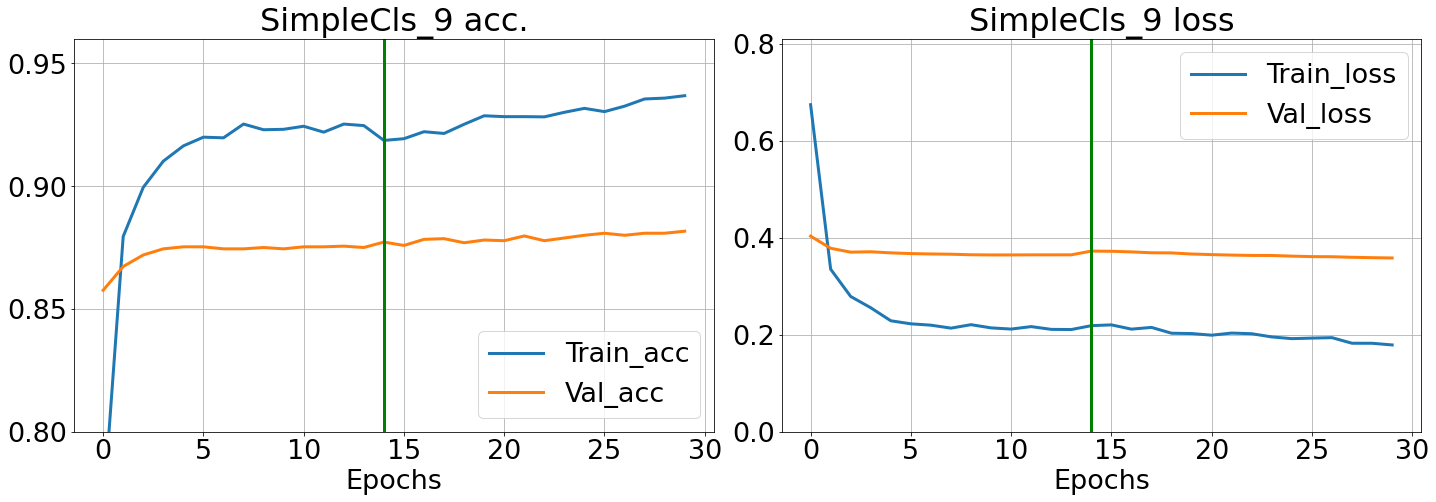

In [ ]:
# Combine histories from frozen and unfrozen models
history_acc    = [*history_frozen.history['accuracy'], *history_unfrozen.history['accuracy']]
history_valacc = [*history_frozen.history['val_accuracy'], *history_unfrozen.history['val_accuracy']]

history_los    = [*history_frozen.history['loss'], *history_unfrozen.history['loss']]
history_valoss = [*history_frozen.history['val_loss'], *history_unfrozen.history['val_loss']]

fig = plt.figure(figsize = (20, 7))
plt.subplot(1, 2, 1)
plt.plot(history_acc, linewidth = 3)
plt.plot(history_valacc, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.8, 0.96)
plt.xticks(np.linspace(0, epochs, 7), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.8, 0.95, 4), fontsize = ticks_size)
plt.title(model_name + '_9 acc.', fontsize = title_size)
plt.legend(['Train_acc', 'Val_acc'], fontsize = label_size, loc = 'lower right')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_los, linewidth = 3)
plt.plot(history_valoss, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.0, 0.81)
plt.xticks(np.linspace(0, epochs, 7), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.0, 0.8, 5), fontsize = ticks_size)
plt.title(model_name + '_9 loss', fontsize = title_size)
plt.legend(['Train_loss', 'Val_loss'], fontsize = label_size)
plt.grid()
plt.tight_layout(pad=0.8)
fig.savefig(model_name + '_' + inp_form + '_9_acc.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# Predict genus and species
pred_gens, pred_specs = predict_gen_spec(model, cv_set, model_name, genus_mapping, emb_matrix)

y_cv = np.asarray(y_cv)
correct_gens  = sum(pred_gens  == y_cv[:, 0])
correct_specs = sum(pred_specs == y_cv[:, 1])

print('Genus   acc: ' + str(np.round( correct_gens  / len(pred_gens),  4 )))
print('Species acc: ' + str(np.round( correct_specs / len(pred_specs), 4 )))

Genus   acc: 0.9671
Species acc: 0.8817


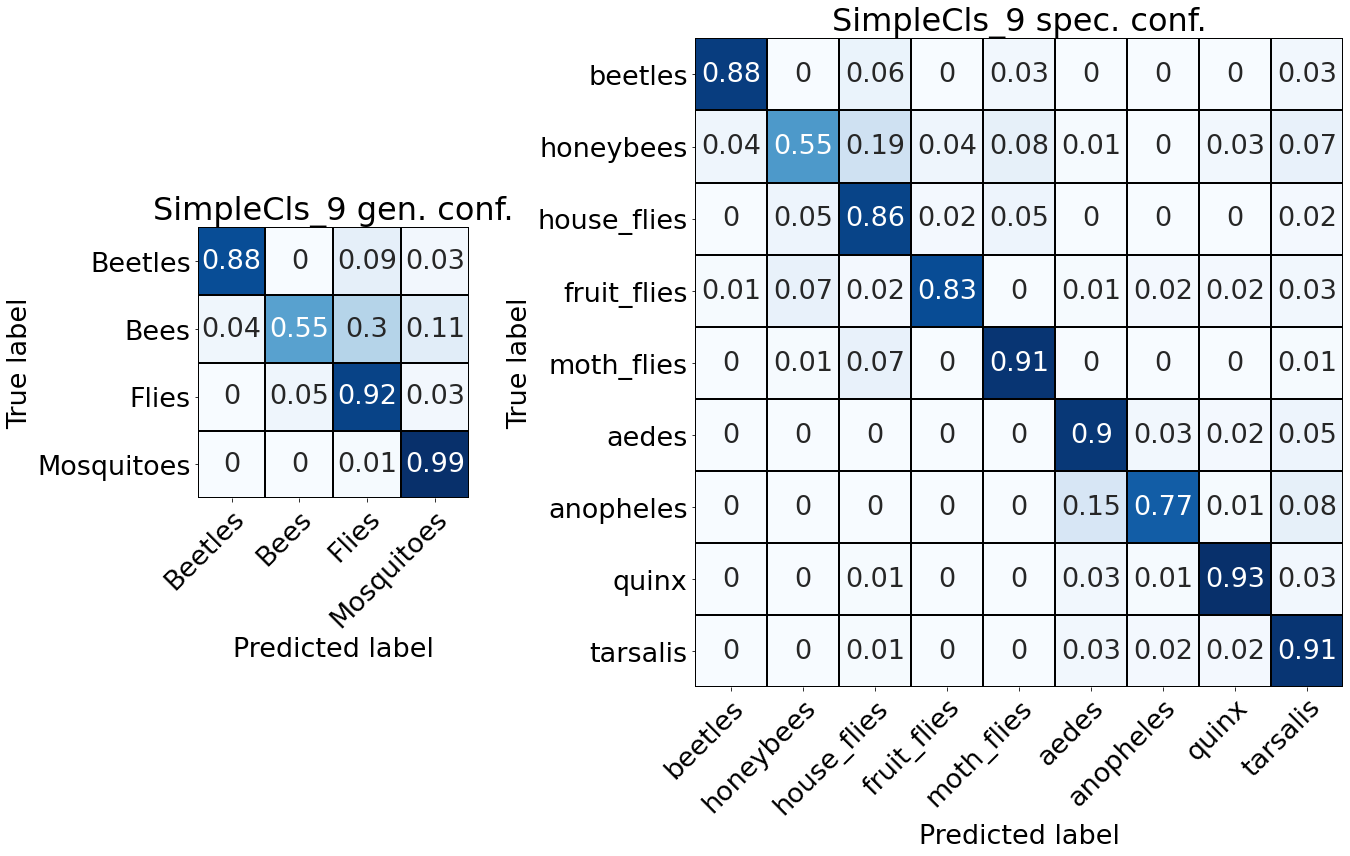

In [ ]:
# Build confusion matrices
gen_conf  = np.round( confusion_matrix(y_cv[:, 0], pred_gens,  normalize = 'true'), 2 )
spec_conf = np.round( confusion_matrix(y_cv[:, 1], pred_specs, normalize = 'true'), 2 )

fig = plt.figure(figsize = (20, 12))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
plt.subplot(gs[0])
plot_heatmap(gen_conf, xticklab = genus, yticklab = genus, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_9 gen. conf.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)

plt.subplot(gs[1])
plot_heatmap(spec_conf, xticklab = species, yticklab = species, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_9 spec. conf.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)
plt.tight_layout()
fig.savefig(model_name + '_' + inp_form + '_9_conf.eps', bbox_inches = 'tight')

Emb_psd

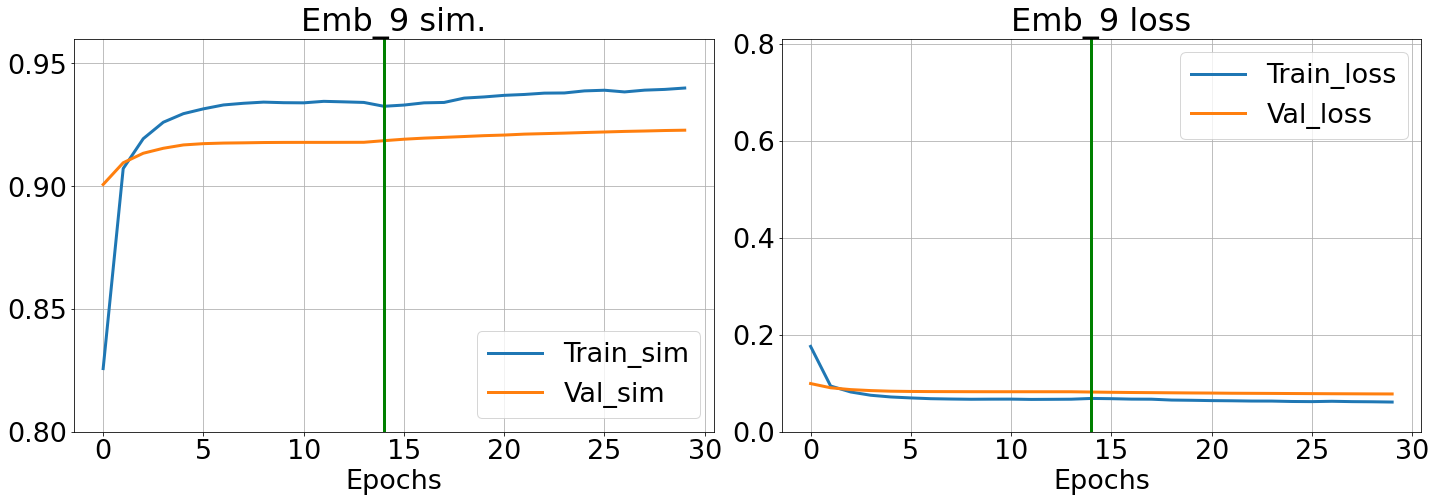

In [ ]:
# Combine histories from frozen and unfrozen models
history_acc    = [*history_frozen.history['similarity'], *history_unfrozen.history['similarity']]
history_valacc = [*history_frozen.history['val_similarity'], *history_unfrozen.history['val_similarity']]

history_los    = [*history_frozen.history['loss'], *history_unfrozen.history['loss']]
history_valoss = [*history_frozen.history['val_loss'], *history_unfrozen.history['val_loss']]

fig = plt.figure(figsize = (20, 7))
plt.subplot(1, 2, 1)
plt.plot(history_acc, linewidth = 3)
plt.plot(history_valacc, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.8, 0.96)
plt.xticks(np.linspace(0, epochs, 7), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.8, 0.95, 4), fontsize = ticks_size)
plt.title(model_name + '_9 sim.', fontsize = title_size)
plt.legend(['Train_sim', 'Val_sim'], fontsize = label_size, loc = 'lower right')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_los, linewidth = 3)
plt.plot(history_valoss, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.0, 0.81)
plt.xticks(np.linspace(0, epochs, 7), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.0, 0.8, 5), fontsize = ticks_size)
plt.title(model_name + '_9 loss', fontsize = title_size)
plt.legend(['Train_loss', 'Val_loss'], fontsize = label_size)
plt.grid()
plt.tight_layout(pad=0.8)
fig.savefig(model_name + '_' + inp_form + '_9_acc.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# Predict genus and species
pred_gens, pred_specs = predict_gen_spec(model, cv_set, model_name, genus_mapping, emb_matrix)

y_cv = np.asarray(y_cv)
correct_gens  = sum(pred_gens  == y_cv[:, 0])
correct_specs = sum(pred_specs == y_cv[:, 1])

print('Genus   acc: ' + str(np.round( correct_gens  / len(pred_gens),  4 )))
print('Species acc: ' + str(np.round( correct_specs / len(pred_specs), 4 )))

Genus   acc: 0.9646
Species acc: 0.859


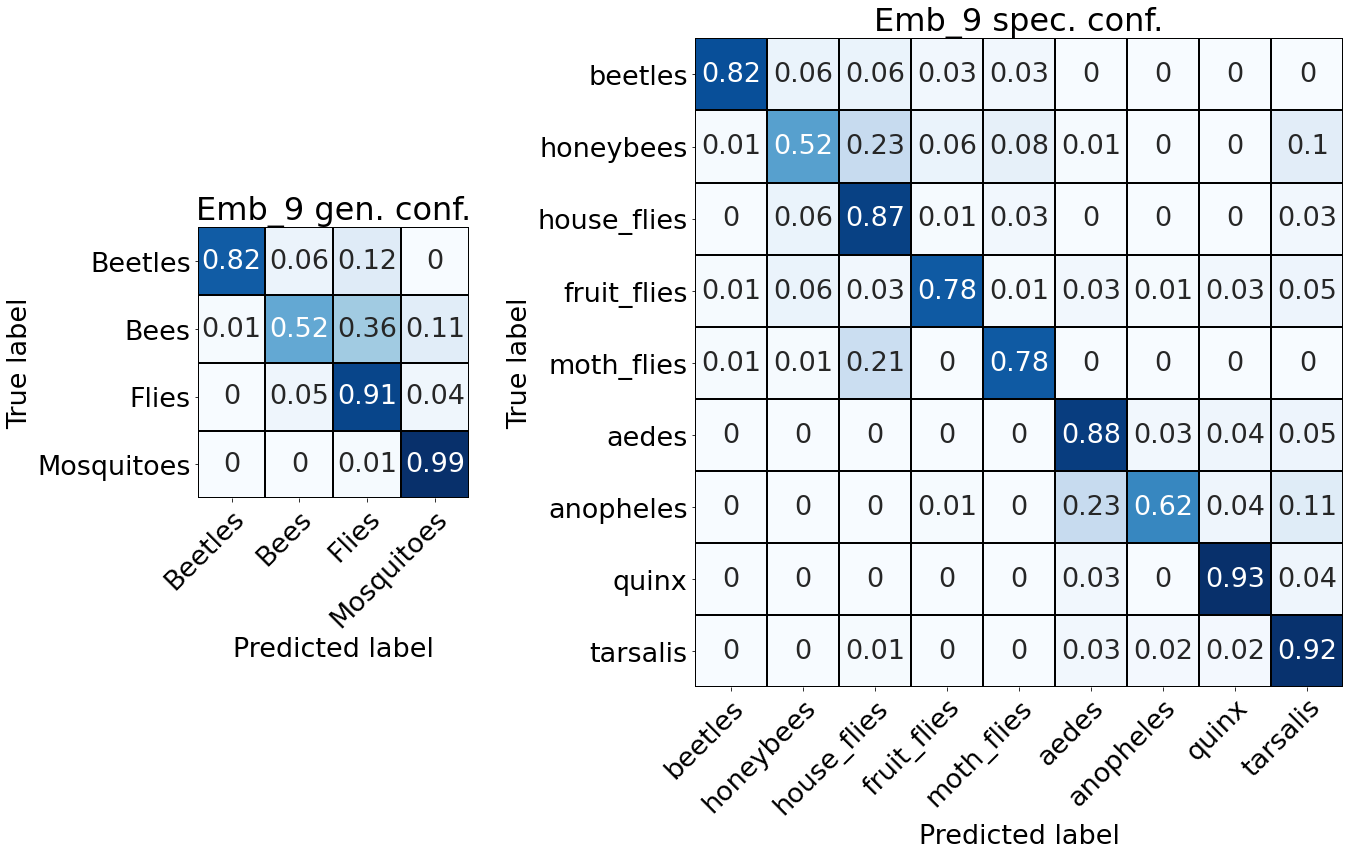

In [ ]:
# Build confusion matrices
gen_conf  = np.round( confusion_matrix(y_cv[:, 0], pred_gens,  normalize = 'true'), 2 )
spec_conf = np.round( confusion_matrix(y_cv[:, 1], pred_specs, normalize = 'true'), 2 )

fig = plt.figure(figsize = (20, 12))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
plt.subplot(gs[0])
plot_heatmap(gen_conf, xticklab = genus, yticklab = genus, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_9 gen. conf.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)

plt.subplot(gs[1])
plot_heatmap(spec_conf, xticklab = species, yticklab = species, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_9 spec. conf.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)
plt.tight_layout()
fig.savefig(model_name + '_' + inp_form + '_9_conf.eps', bbox_inches = 'tight')

SimpleEmbCls_psd

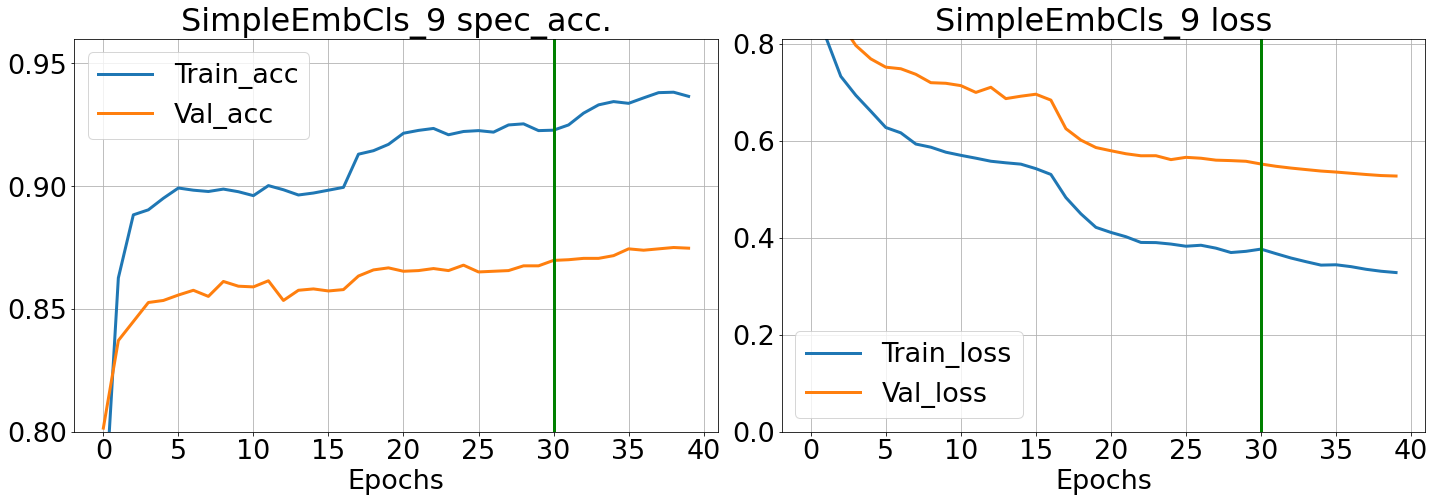

In [ ]:
# Combine histories from frozen and unfrozen models
history_acc    = [*history_frozen.history['species_accuracy'], *history_unfrozen.history['species_accuracy']]
history_valacc = [*history_frozen.history['val_species_accuracy'], *history_unfrozen.history['val_species_accuracy']]

history_los    = [*history_frozen.history['loss'], *history_unfrozen.history['loss']]
history_valoss = [*history_frozen.history['val_loss'], *history_unfrozen.history['val_loss']]

fig = plt.figure(figsize = (20, 7))
plt.subplot(1, 2, 1)
plt.plot(history_acc, linewidth = 3)
plt.plot(history_valacc, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.8, 0.96)
plt.xticks(np.linspace(0, epochs+10, 9), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.8, 0.95, 4), fontsize = ticks_size)
plt.title(model_name + '_9 spec_acc.', fontsize = title_size)
plt.legend(['Train_acc', 'Val_acc'], fontsize = label_size)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_los, linewidth = 3)
plt.plot(history_valoss, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.0, 0.81)
plt.xticks(np.linspace(0, epochs+10, 9), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.0, 0.8, 5), fontsize = ticks_size)
plt.title(model_name + '_9 loss', fontsize = title_size)
plt.legend(['Train_loss', 'Val_loss'], fontsize = label_size)
plt.grid()
plt.tight_layout(pad=0.8)
fig.savefig(model_name + '_' + inp_form + '_9_acc.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# Predict genus and species
pred_gens, pred_specs = predict_gen_spec(model, cv_set, model_name, genus_mapping, emb_matrix)

y_cv = np.asarray(y_cv)
correct_gens  = sum(pred_gens  == y_cv[:, 0])
correct_specs = sum(pred_specs == y_cv[:, 1])

print('Genus   acc: ' + str(np.round( correct_gens  / len(pred_gens),  4 )))
print('Species acc: ' + str(np.round( correct_specs / len(pred_specs), 4 )))

Genus   acc: 0.9654
Species acc: 0.8748


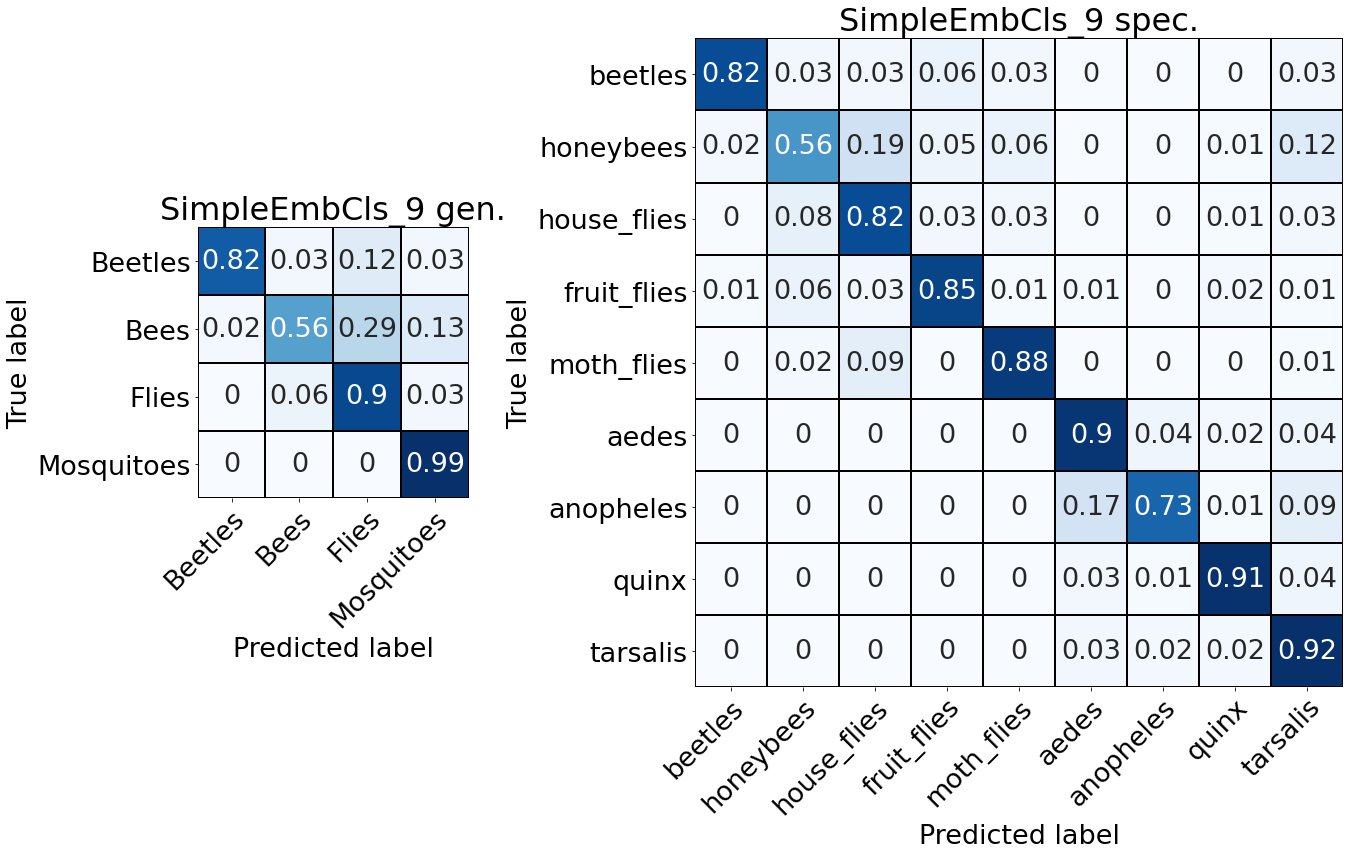

In [ ]:
# Build confusion matrices
gen_conf  = np.round( confusion_matrix(y_cv[:, 0], pred_gens,  normalize = 'true'), 2 )
spec_conf = np.round( confusion_matrix(y_cv[:, 1], pred_specs, normalize = 'true'), 2 )

fig = plt.figure(figsize = (20, 12))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
plt.subplot(gs[0])
plot_heatmap(gen_conf, xticklab = genus, yticklab = genus, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_9 gen.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)

plt.subplot(gs[1])
plot_heatmap(spec_conf, xticklab = species, yticklab = species, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_9 spec.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)
plt.tight_layout()
fig.savefig(model_name + '_' + inp_form + '_9_conf.eps', bbox_inches = 'tight')

HieraCls_psd

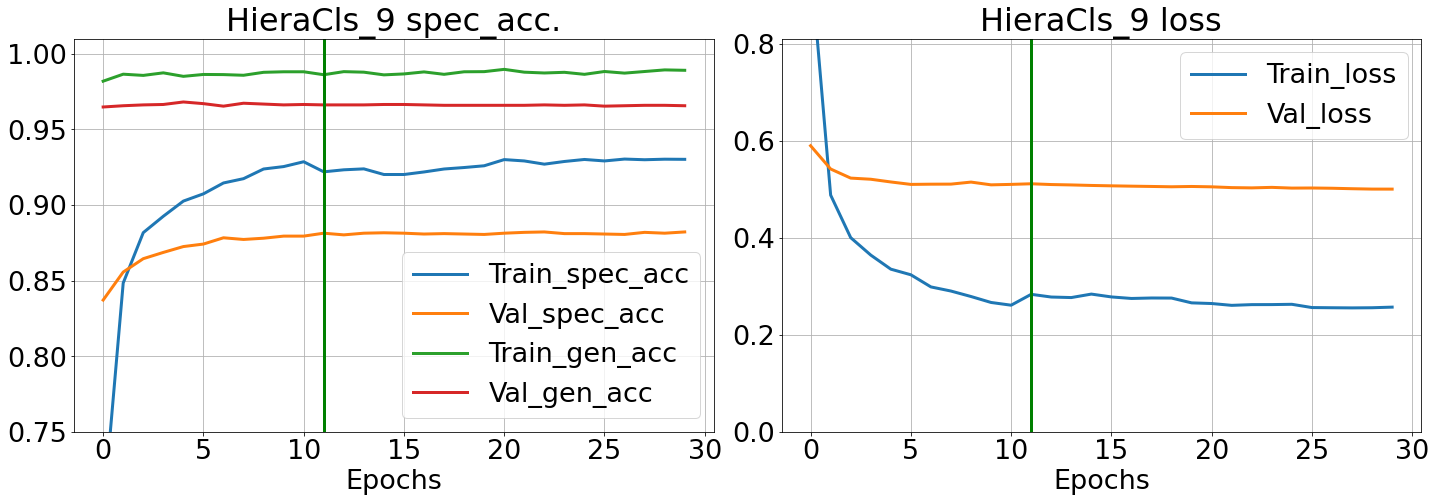

In [ ]:
# Combine histories from frozen and unfrozen models
history_acc    = [*history_frozen.history['species_accuracy'], *history_unfrozen.history['species_accuracy']]
history_valacc = [*history_frozen.history['val_species_accuracy'], *history_unfrozen.history['val_species_accuracy']]
history_gen_acc    = [*history_frozen.history['genus_accuracy'], *history_unfrozen.history['genus_accuracy']]
history_gen_valacc = [*history_frozen.history['val_genus_accuracy'], *history_unfrozen.history['val_genus_accuracy']]

history_los    = [*history_frozen.history['loss'], *history_unfrozen.history['loss']]
history_valoss = [*history_frozen.history['val_loss'], *history_unfrozen.history['val_loss']]

fig = plt.figure(figsize = (20, 7))
plt.subplot(1, 2, 1)
plt.plot(history_acc, linewidth = 3)
plt.plot(history_valacc, linewidth = 3)
plt.plot(history_gen_acc, linewidth = 3)
plt.plot(history_gen_valacc, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.75, 1.01)
plt.xticks(np.linspace(0, epochs, 7), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.75, 1.0, 6), fontsize = ticks_size)
plt.title(model_name + '_9 spec_acc.', fontsize = title_size)
plt.legend(['Train_spec_acc', 'Val_spec_acc', 'Train_gen_acc', 'Val_gen_acc'], fontsize = label_size)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_los, linewidth = 3)
plt.plot(history_valoss, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.0, 0.81)
plt.xticks(np.linspace(0, epochs, 7), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.0, 0.8, 5), fontsize = ticks_size)
plt.title(model_name + '_9 loss', fontsize = title_size)
plt.legend(['Train_loss', 'Val_loss'], fontsize = label_size)
plt.grid()
plt.tight_layout(pad=0.8)
fig.savefig(model_name + '_' + inp_form + '_9_acc.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# Predict genus and species
pred_gens, pred_specs = predict_gen_spec(model, cv_set, model_name, genus_mapping, emb_matrix)

y_cv = np.asarray(y_cv)
correct_gens  = sum(pred_gens  == y_cv[:, 0])
correct_specs = sum(pred_specs == y_cv[:, 1])

print('Genus   acc: ' + str(np.round( correct_gens  / len(pred_gens),  4 )))
print('Species acc: ' + str(np.round( correct_specs / len(pred_specs), 4 )))

Genus   acc: 0.9657
Species acc: 0.8822


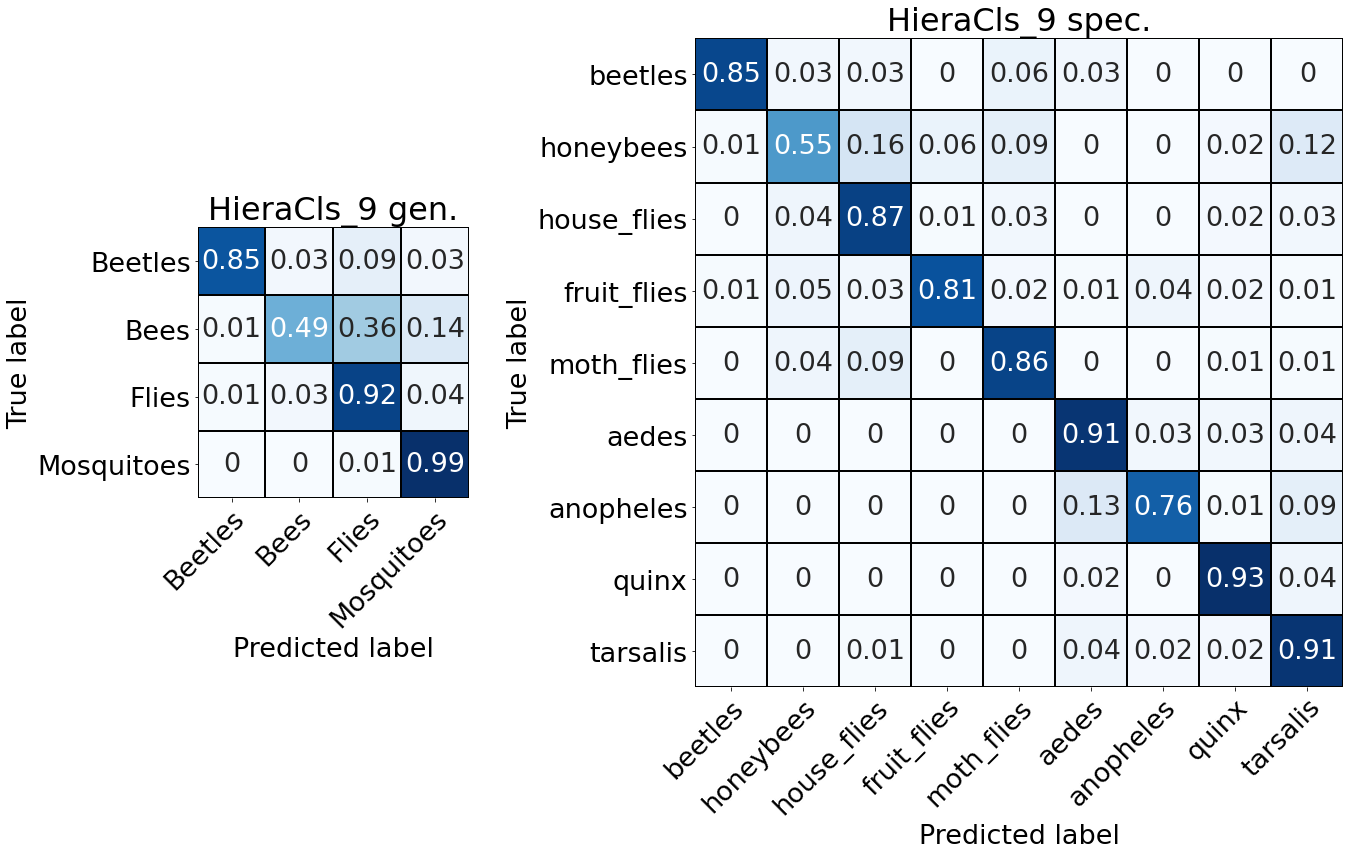

In [ ]:
# Build confusion matrices
gen_conf  = np.round( confusion_matrix(y_cv[:, 0], pred_gens,  normalize = 'true'), 2 )
spec_conf = np.round( confusion_matrix(y_cv[:, 1], pred_specs, normalize = 'true'), 2 )

fig = plt.figure(figsize = (20, 12))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
plt.subplot(gs[0])
plot_heatmap(gen_conf, xticklab = genus, yticklab = genus, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_9 gen.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)

plt.subplot(gs[1])
plot_heatmap(spec_conf, xticklab = species, yticklab = species, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_9 spec.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)
plt.tight_layout()
fig.savefig(model_name + '_' + inp_form + '_9_conf.eps', bbox_inches = 'tight')

HieraEmbCls_psd

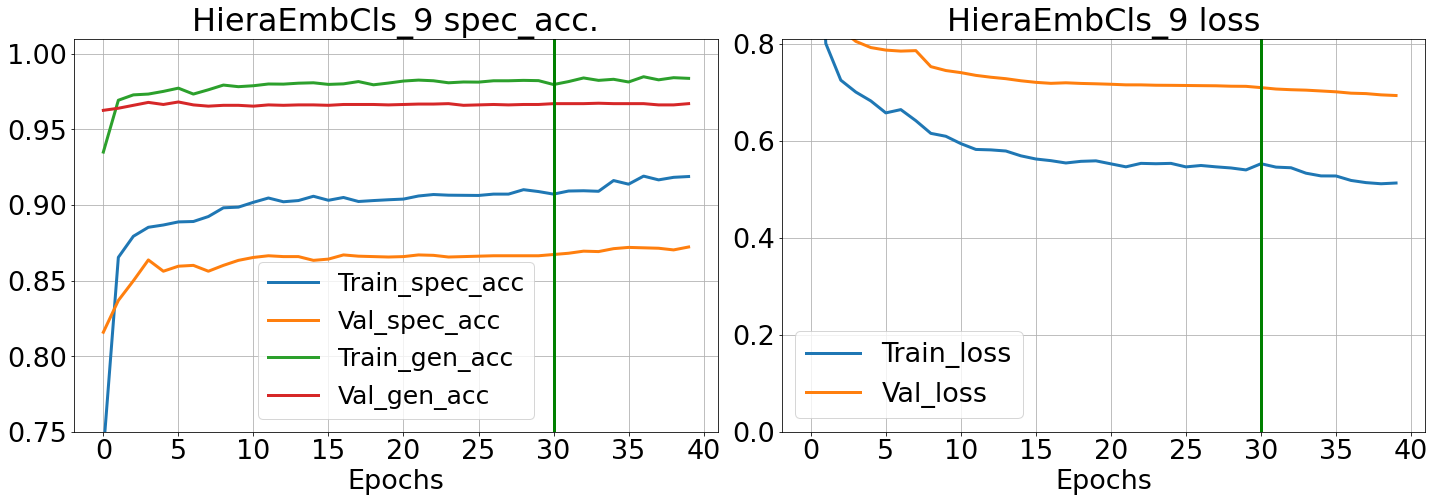

In [ ]:
# Combine histories from frozen and unfrozen models
history_acc    = [*history_frozen.history['species_accuracy'], *history_unfrozen.history['species_accuracy']]
history_valacc = [*history_frozen.history['val_species_accuracy'], *history_unfrozen.history['val_species_accuracy']]
history_gen_acc    = [*history_frozen.history['genus_accuracy'], *history_unfrozen.history['genus_accuracy']]
history_gen_valacc = [*history_frozen.history['val_genus_accuracy'], *history_unfrozen.history['val_genus_accuracy']]

history_los    = [*history_frozen.history['loss'], *history_unfrozen.history['loss']]
history_valoss = [*history_frozen.history['val_loss'], *history_unfrozen.history['val_loss']]

fig = plt.figure(figsize = (20, 7))
plt.subplot(1, 2, 1)
plt.plot(history_acc, linewidth = 3)
plt.plot(history_valacc, linewidth = 3)
plt.plot(history_gen_acc, linewidth = 3)
plt.plot(history_gen_valacc, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.75, 1.01)
plt.xticks(np.linspace(0, epochs+10, 9), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.75, 1.0, 6), fontsize = ticks_size)
plt.title(model_name + '_9 spec_acc.', fontsize = title_size)
plt.legend(['Train_spec_acc', 'Val_spec_acc', 'Train_gen_acc', 'Val_gen_acc'], fontsize = label_size-2)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_los, linewidth = 3)
plt.plot(history_valoss, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.0, 0.81)
plt.xticks(np.linspace(0, epochs+10, 9), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.0, 0.8, 5), fontsize = ticks_size)
plt.title(model_name + '_9 loss', fontsize = title_size)
plt.legend(['Train_loss', 'Val_loss'], fontsize = label_size)
plt.grid()
plt.tight_layout(pad=0.8)
fig.savefig(model_name + '_' + inp_form + '_9_acc.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# Predict genus and species
pred_gens, pred_specs = predict_gen_spec(model, cv_set, model_name, genus_mapping, emb_matrix)

y_cv = np.asarray(y_cv)
correct_gens  = sum(pred_gens  == y_cv[:, 0])
correct_specs = sum(pred_specs == y_cv[:, 1])

print('Genus   acc: ' + str(np.round( correct_gens  / len(pred_gens),  4 )))
print('Species acc: ' + str(np.round( correct_specs / len(pred_specs), 4 )))

Genus   acc: 0.9671
Species acc: 0.8723


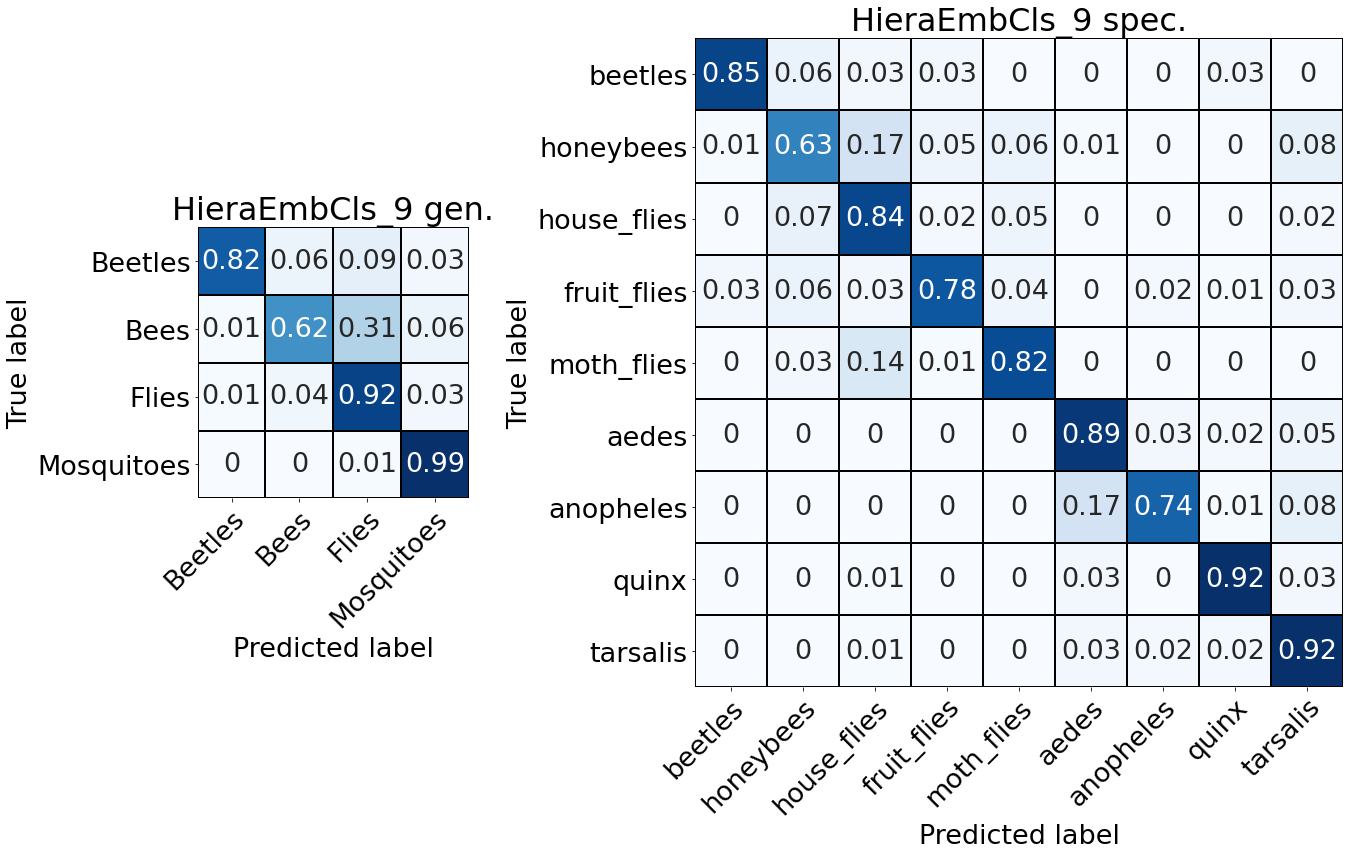

In [ ]:
# Build confusion matrices
gen_conf  = np.round( confusion_matrix(y_cv[:, 0], pred_gens,  normalize = 'true'), 2 )
spec_conf = np.round( confusion_matrix(y_cv[:, 1], pred_specs, normalize = 'true'), 2 )

fig = plt.figure(figsize = (20, 12))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
plt.subplot(gs[0])
plot_heatmap(gen_conf, xticklab = genus, yticklab = genus, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_9 gen.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)

plt.subplot(gs[1])
plot_heatmap(spec_conf, xticklab = species, yticklab = species, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_9 spec.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)
plt.tight_layout()
fig.savefig(model_name + '_' + inp_form + '_9_conf.eps', bbox_inches = 'tight')

## Spectro

SimpleCls_spectro

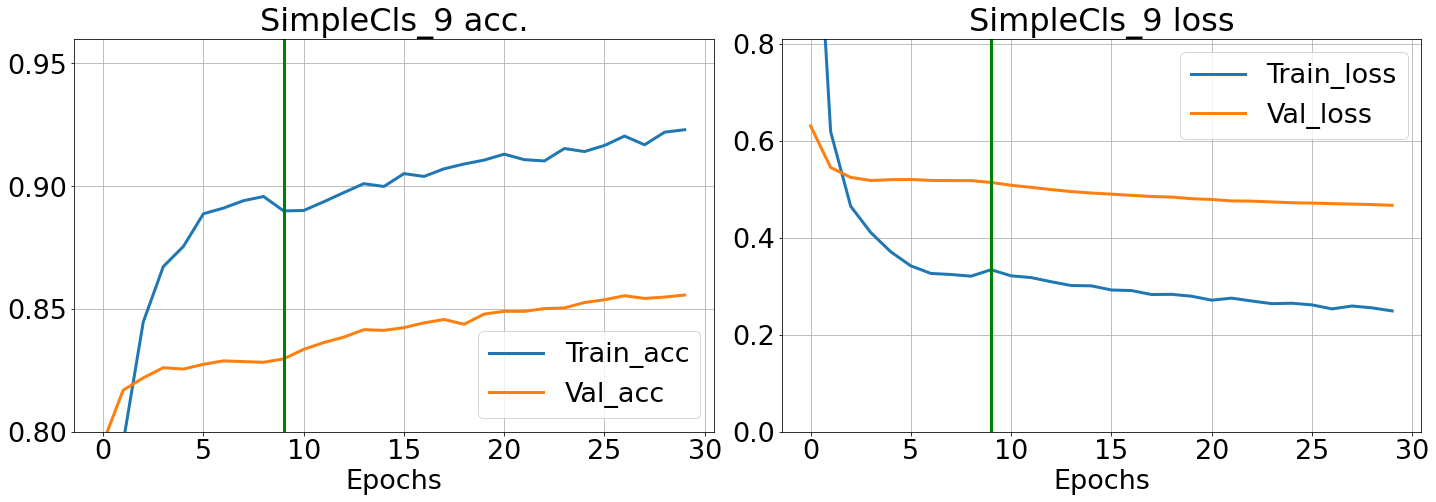

In [ ]:
# Combine histories from frozen and unfrozen models
history_acc    = [*history_frozen.history['accuracy'], *history_unfrozen.history['accuracy']]
history_valacc = [*history_frozen.history['val_accuracy'], *history_unfrozen.history['val_accuracy']]

history_los    = [*history_frozen.history['loss'], *history_unfrozen.history['loss']]
history_valoss = [*history_frozen.history['val_loss'], *history_unfrozen.history['val_loss']]

fig = plt.figure(figsize = (20, 7))
plt.subplot(1, 2, 1)
plt.plot(history_acc, linewidth = 3)
plt.plot(history_valacc, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.8, 0.96)
plt.xticks(np.linspace(0, epochs, 7), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.8, 0.95, 4), fontsize = ticks_size)
plt.title(model_name + '_9 acc.', fontsize = title_size)
plt.legend(['Train_acc', 'Val_acc'], fontsize = label_size, loc = 'lower right')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_los, linewidth = 3)
plt.plot(history_valoss, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.0, 0.81)
plt.xticks(np.linspace(0, epochs, 7), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.0, 0.8, 5), fontsize = ticks_size)
plt.title(model_name + '_9 loss', fontsize = title_size)
plt.legend(['Train_loss', 'Val_loss'], fontsize = label_size)
plt.grid()
plt.tight_layout(pad=0.8)
fig.savefig(model_name + '_' + inp_form + '_9_acc.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# Predict genus and species
pred_gens, pred_specs = predict_gen_spec(model, cv_set, model_name, genus_mapping, emb_matrix)

y_cv = np.asarray(y_cv)
correct_gens  = sum(pred_gens  == y_cv[:, 0])
correct_specs = sum(pred_specs == y_cv[:, 1])

print('Genus   acc: ' + str(np.round( correct_gens  / len(pred_gens),  4 )))
print('Species acc: ' + str(np.round( correct_specs / len(pred_specs), 4 )))

Genus   acc: 0.961
Species acc: 0.8557


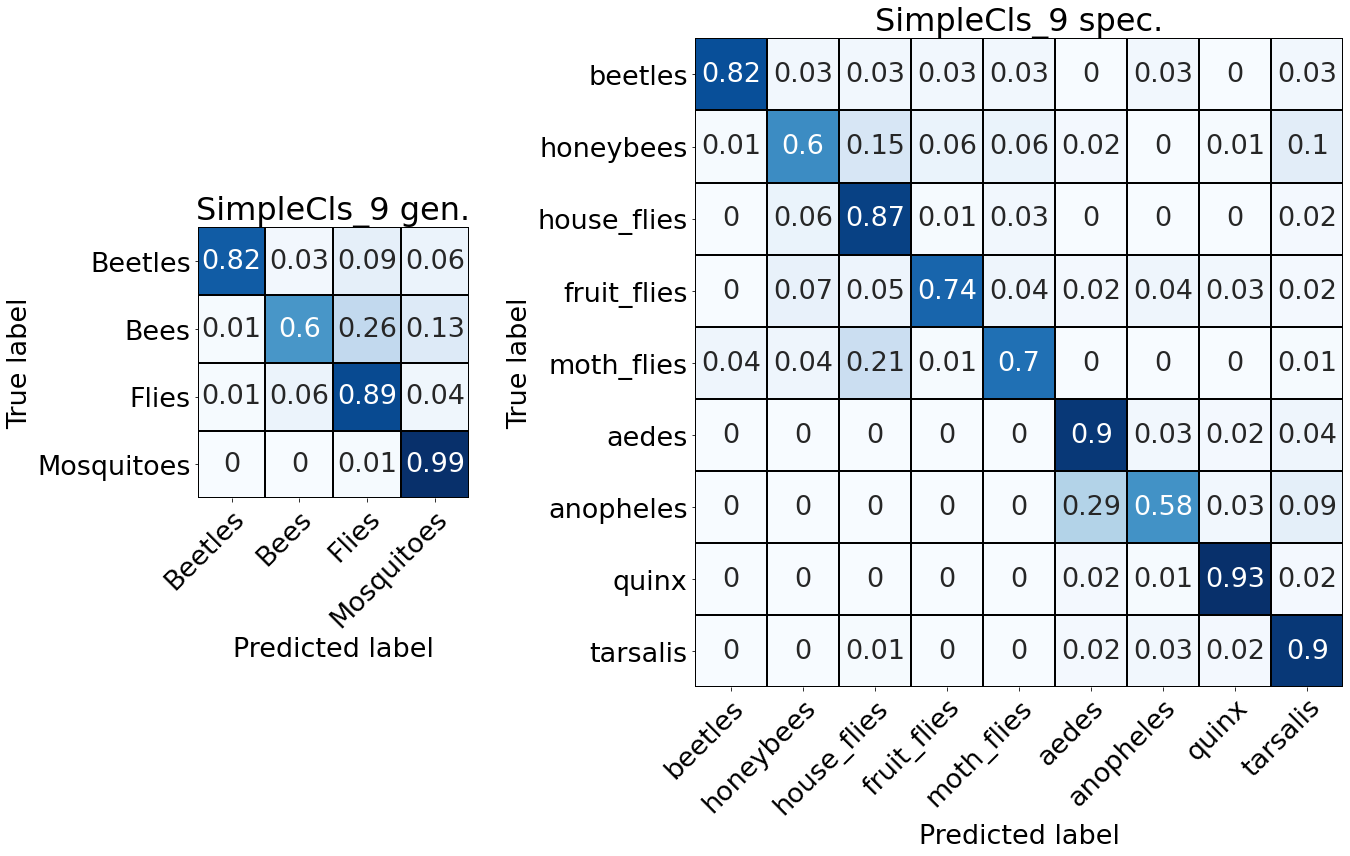

In [ ]:
# Build confusion matrices
gen_conf  = np.round( confusion_matrix(y_cv[:, 0], pred_gens,  normalize = 'true'), 2 )
spec_conf = np.round( confusion_matrix(y_cv[:, 1], pred_specs, normalize = 'true'), 2 )

fig = plt.figure(figsize = (20, 12))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
plt.subplot(gs[0])
plot_heatmap(gen_conf, xticklab = genus, yticklab = genus, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_9 gen.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)

plt.subplot(gs[1])
plot_heatmap(spec_conf, xticklab = species, yticklab = species, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_9 spec.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)
plt.tight_layout()
fig.savefig(model_name + '_' + inp_form + '_9_conf.eps', bbox_inches = 'tight')

Emb_spectro

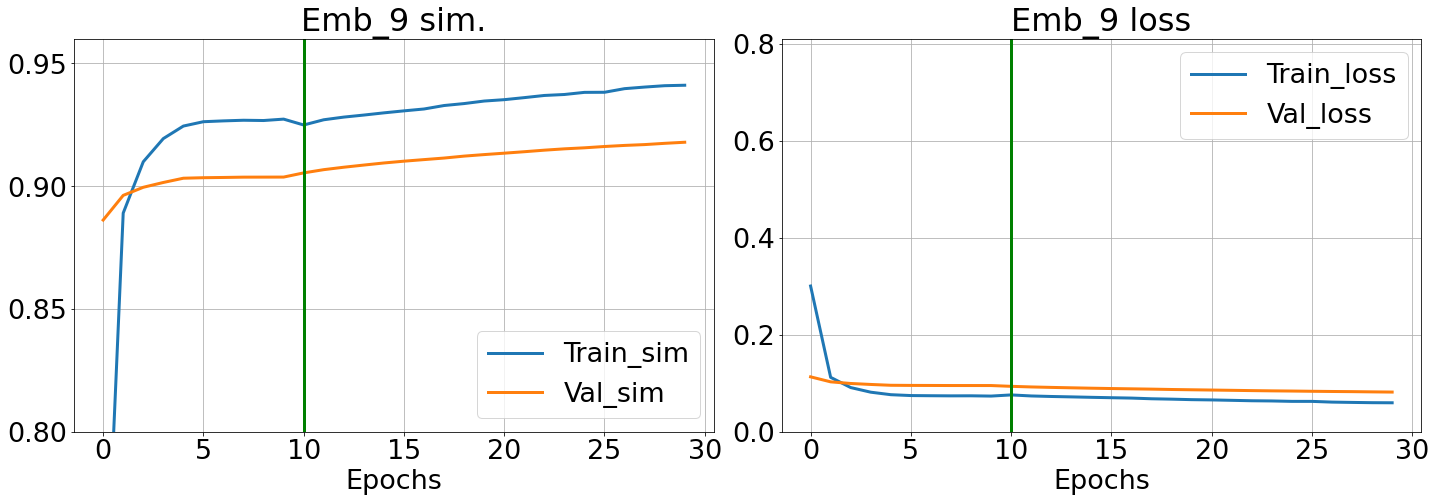

In [ ]:
# Combine histories from frozen and unfrozen models
history_acc    = [*history_frozen.history['similarity'], *history_unfrozen.history['similarity']]
history_valacc = [*history_frozen.history['val_similarity'], *history_unfrozen.history['val_similarity']]

history_los    = [*history_frozen.history['loss'], *history_unfrozen.history['loss']]
history_valoss = [*history_frozen.history['val_loss'], *history_unfrozen.history['val_loss']]

fig = plt.figure(figsize = (20, 7))
plt.subplot(1, 2, 1)
plt.plot(history_acc, linewidth = 3)
plt.plot(history_valacc, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.8, 0.96)
plt.xticks(np.linspace(0, epochs, 7), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.8, 0.95, 4), fontsize = ticks_size)
plt.title(model_name + '_9 sim.', fontsize = title_size)
plt.legend(['Train_sim', 'Val_sim'], fontsize = label_size, loc = 'lower right')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_los, linewidth = 3)
plt.plot(history_valoss, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.0, 0.81)
plt.xticks(np.linspace(0, epochs, 7), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.0, 0.8, 5), fontsize = ticks_size)
plt.title(model_name + '_9 loss', fontsize = title_size)
plt.legend(['Train_loss', 'Val_loss'], fontsize = label_size)
plt.grid()
plt.tight_layout(pad=0.8)
fig.savefig(model_name + '_' + inp_form + '_9_acc.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# Predict genus and species
pred_gens, pred_specs = predict_gen_spec(model, cv_set, model_name, genus_mapping, emb_matrix)

y_cv = np.asarray(y_cv)
correct_gens  = sum(pred_gens  == y_cv[:, 0])
correct_specs = sum(pred_specs == y_cv[:, 1])

print('Genus   acc: ' + str(np.round( correct_gens  / len(pred_gens),  4 )))
print('Species acc: ' + str(np.round( correct_specs / len(pred_specs), 4 )))

Genus   acc: 0.9657
Species acc: 0.8424


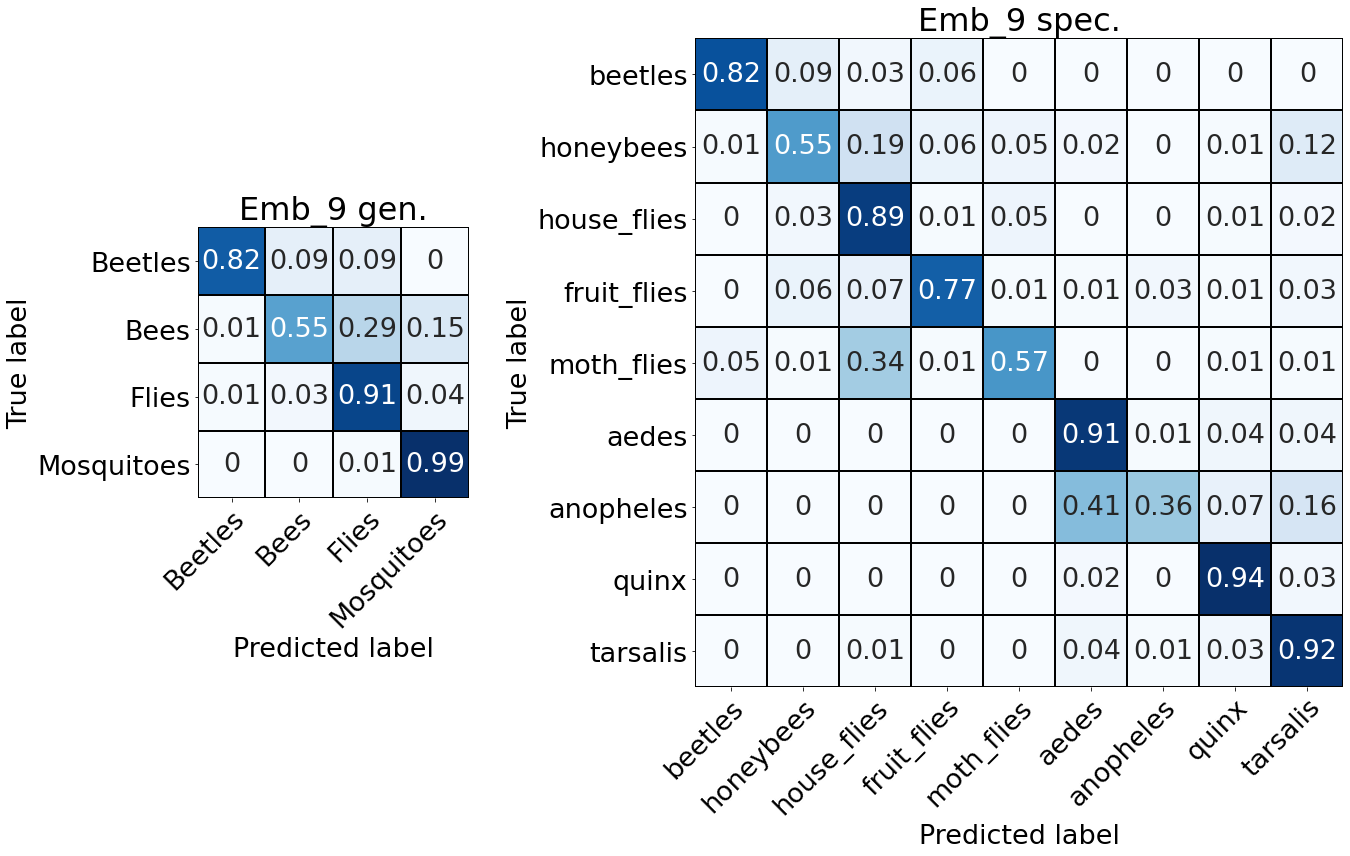

In [ ]:
# Build confusion matrices
gen_conf  = np.round( confusion_matrix(y_cv[:, 0], pred_gens,  normalize = 'true'), 2 )
spec_conf = np.round( confusion_matrix(y_cv[:, 1], pred_specs, normalize = 'true'), 2 )

fig = plt.figure(figsize = (20, 12))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
plt.subplot(gs[0])
plot_heatmap(gen_conf, xticklab = genus, yticklab = genus, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_9 gen.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)

plt.subplot(gs[1])
plot_heatmap(spec_conf, xticklab = species, yticklab = species, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_9 spec.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)
plt.tight_layout()
fig.savefig(model_name + '_' + inp_form + '_9_conf.eps', bbox_inches = 'tight')

SimpleEmbCls_spectro

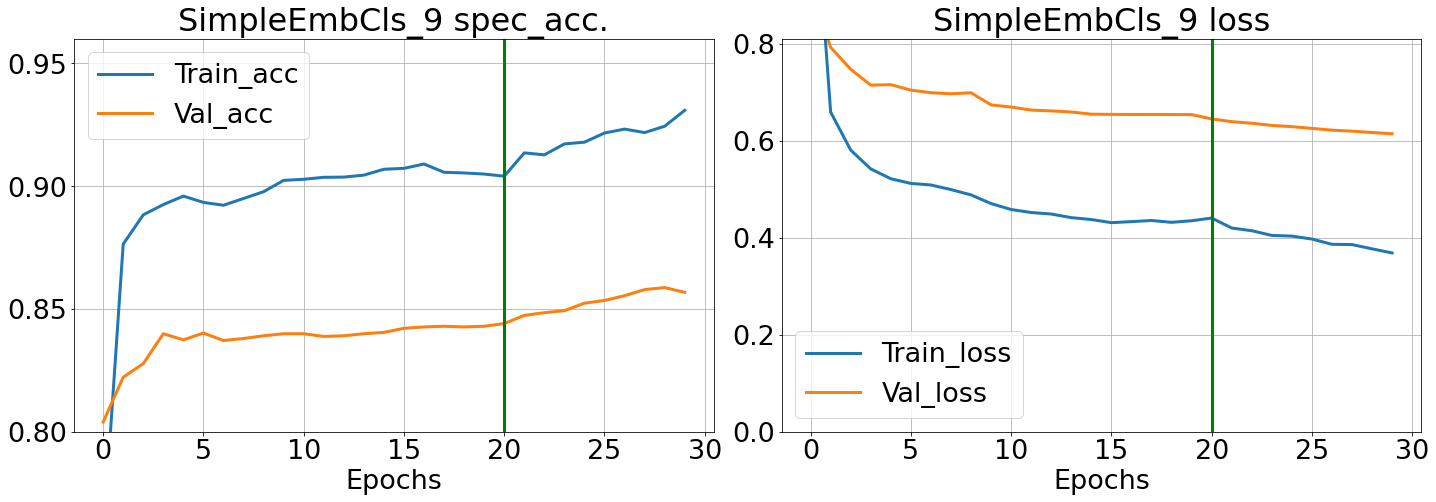

In [ ]:
# Combine histories from frozen and unfrozen models
history_acc    = [*history_frozen.history['species_accuracy'], *history_unfrozen.history['species_accuracy']]
history_valacc = [*history_frozen.history['val_species_accuracy'], *history_unfrozen.history['val_species_accuracy']]

history_los    = [*history_frozen.history['loss'], *history_unfrozen.history['loss']]
history_valoss = [*history_frozen.history['val_loss'], *history_unfrozen.history['val_loss']]

fig = plt.figure(figsize = (20, 7))
plt.subplot(1, 2, 1)
plt.plot(history_acc, linewidth = 3)
plt.plot(history_valacc, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.8, 0.96)
plt.xticks(np.linspace(0, epochs, 7), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.8, 0.95, 4), fontsize = ticks_size)
plt.title(model_name + '_9 spec_acc.', fontsize = title_size)
plt.legend(['Train_acc', 'Val_acc'], fontsize = label_size)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_los, linewidth = 3)
plt.plot(history_valoss, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.0, 0.81)
plt.xticks(np.linspace(0, epochs, 7), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.0, 0.8, 5), fontsize = ticks_size)
plt.title(model_name + '_9 loss', fontsize = title_size)
plt.legend(['Train_loss', 'Val_loss'], fontsize = label_size)
plt.grid()
plt.tight_layout(pad=0.8)
fig.savefig(model_name + '_' + inp_form + '_9_acc.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# Predict genus and species
pred_gens, pred_specs = predict_gen_spec(model, cv_set, model_name, genus_mapping, emb_matrix)

y_cv = np.asarray(y_cv)
correct_gens  = sum(pred_gens  == y_cv[:, 0])
correct_specs = sum(pred_specs == y_cv[:, 1])

print('Genus   acc: ' + str(np.round( correct_gens  / len(pred_gens),  4 )))
print('Species acc: ' + str(np.round( correct_specs / len(pred_specs), 4 )))

Genus   acc: 0.9613
Species acc: 0.8568


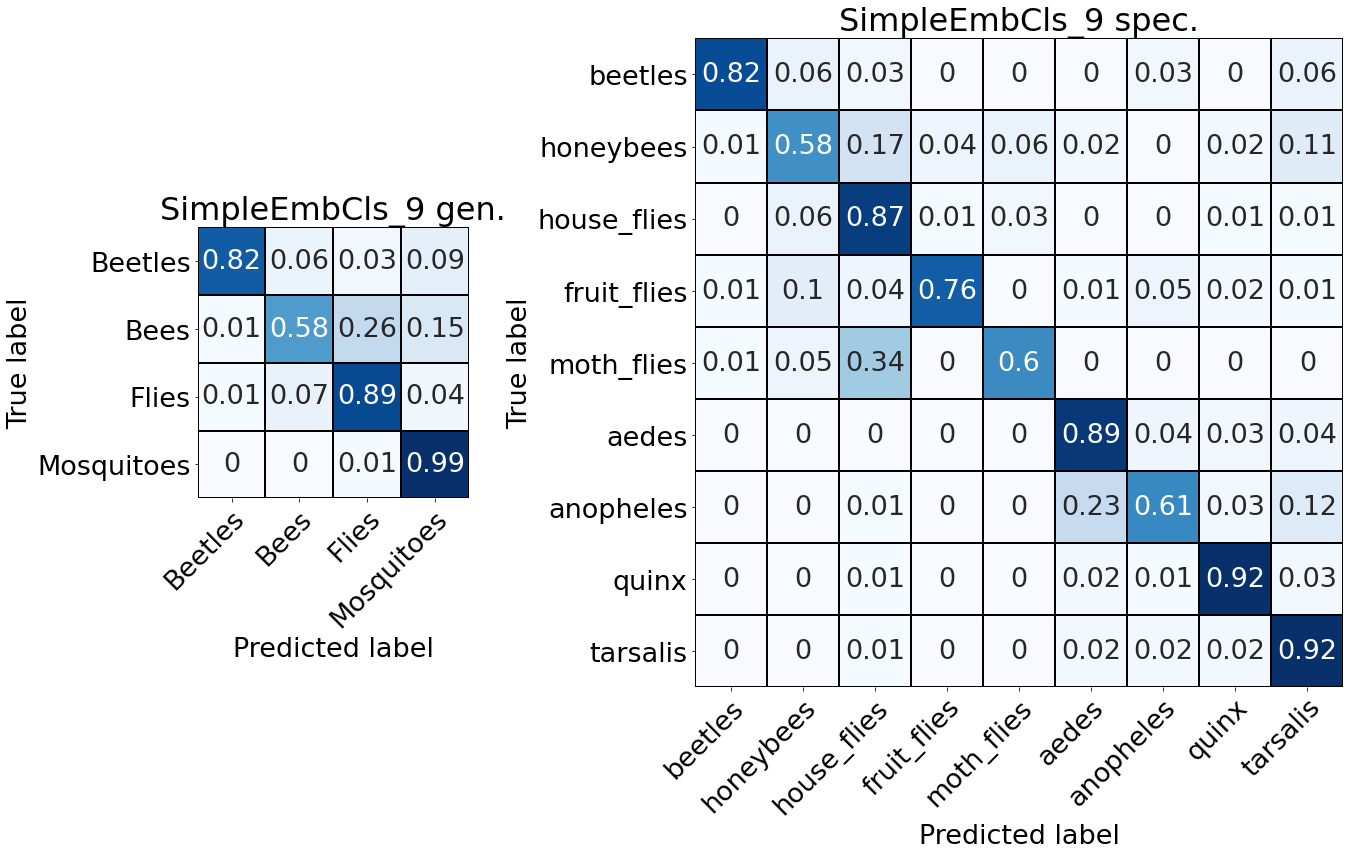

In [ ]:
# Build confusion matrices
gen_conf  = np.round( confusion_matrix(y_cv[:, 0], pred_gens,  normalize = 'true'), 2 )
spec_conf = np.round( confusion_matrix(y_cv[:, 1], pred_specs, normalize = 'true'), 2 )

fig = plt.figure(figsize = (20, 12))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
plt.subplot(gs[0])
plot_heatmap(gen_conf, xticklab = genus, yticklab = genus, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_9 gen.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)

plt.subplot(gs[1])
plot_heatmap(spec_conf, xticklab = species, yticklab = species, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_9 spec.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)
plt.tight_layout()
fig.savefig(model_name + '_' + inp_form + '_9_conf.eps', bbox_inches = 'tight')

HieraCls_spectro

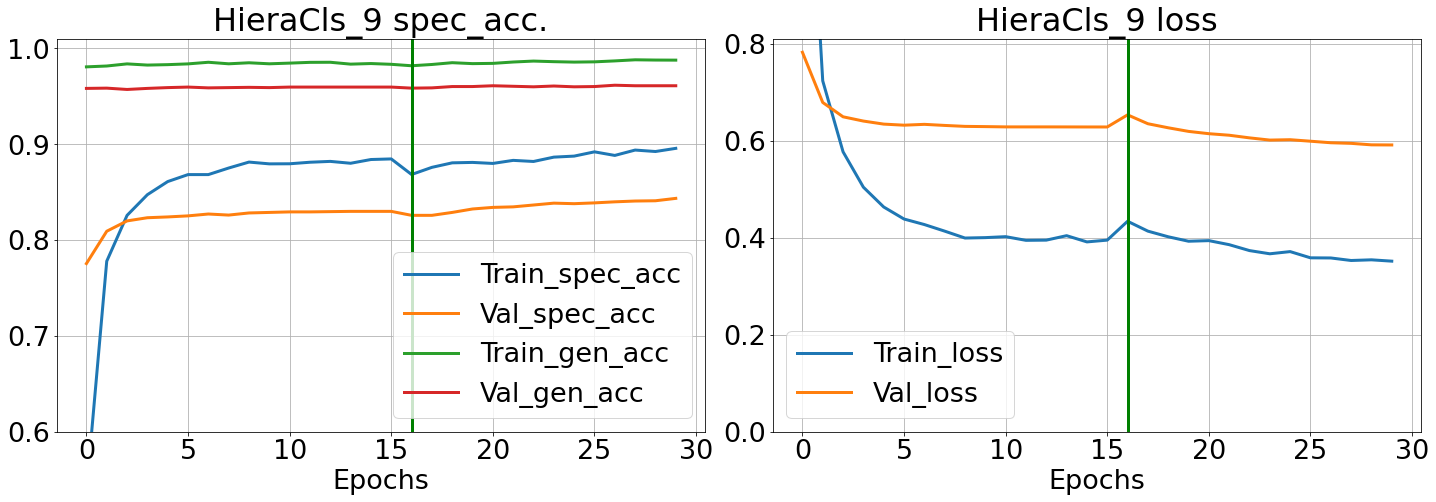

In [ ]:
# Combine histories from frozen and unfrozen models
history_acc    = [*history_frozen.history['species_accuracy'], *history_unfrozen.history['species_accuracy']]
history_valacc = [*history_frozen.history['val_species_accuracy'], *history_unfrozen.history['val_species_accuracy']]
history_gen_acc    = [*history_frozen.history['genus_accuracy'], *history_unfrozen.history['genus_accuracy']]
history_gen_valacc = [*history_frozen.history['val_genus_accuracy'], *history_unfrozen.history['val_genus_accuracy']]

history_los    = [*history_frozen.history['loss'], *history_unfrozen.history['loss']]
history_valoss = [*history_frozen.history['val_loss'], *history_unfrozen.history['val_loss']]

fig = plt.figure(figsize = (20, 7))
plt.subplot(1, 2, 1)
plt.plot(history_acc, linewidth = 3)
plt.plot(history_valacc, linewidth = 3)
plt.plot(history_gen_acc, linewidth = 3)
plt.plot(history_gen_valacc, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.6, 1.01)
plt.xticks(np.linspace(0, epochs, 7), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.6, 1.0, 5), fontsize = ticks_size)
plt.title(model_name + '_9 spec_acc.', fontsize = title_size)
plt.legend(['Train_spec_acc', 'Val_spec_acc', 'Train_gen_acc', 'Val_gen_acc'], fontsize = label_size)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_los, linewidth = 3)
plt.plot(history_valoss, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.0, 0.81)
plt.xticks(np.linspace(0, epochs, 7), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.0, 0.8, 5), fontsize = ticks_size)
plt.title(model_name + '_9 loss', fontsize = title_size)
plt.legend(['Train_loss', 'Val_loss'], fontsize = label_size)
plt.grid()
plt.tight_layout(pad=0.8)
fig.savefig(model_name + '_' + inp_form + '_9_acc.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# Predict genus and species
pred_gens, pred_specs = predict_gen_spec(model, cv_set, model_name, genus_mapping, emb_matrix)

y_cv = np.asarray(y_cv)
correct_gens  = sum(pred_gens  == y_cv[:, 0])
correct_specs = sum(pred_specs == y_cv[:, 1])

print('Genus   acc: ' + str(np.round( correct_gens  / len(pred_gens),  4 )))
print('Species acc: ' + str(np.round( correct_specs / len(pred_specs), 4 )))

Genus   acc: 0.961
Species acc: 0.8435


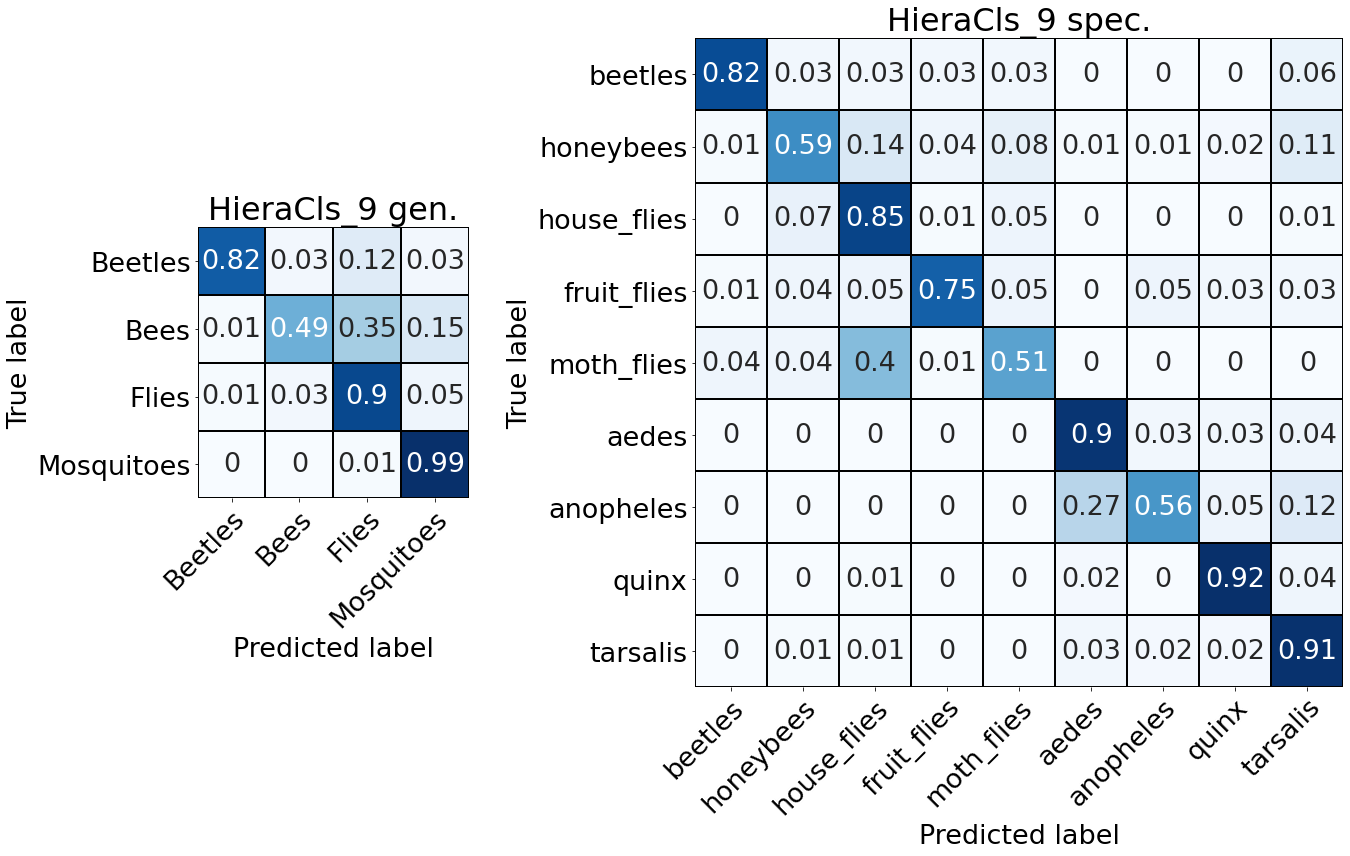

In [ ]:
# Build confusion matrices
gen_conf  = np.round( confusion_matrix(y_cv[:, 0], pred_gens,  normalize = 'true'), 2 )
spec_conf = np.round( confusion_matrix(y_cv[:, 1], pred_specs, normalize = 'true'), 2 )

fig = plt.figure(figsize = (20, 12))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
plt.subplot(gs[0])
plot_heatmap(gen_conf, xticklab = genus, yticklab = genus, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_9 gen.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)

plt.subplot(gs[1])
plot_heatmap(spec_conf, xticklab = species, yticklab = species, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_9 spec.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)
plt.tight_layout()
fig.savefig(model_name + '_' + inp_form + '_9_conf.eps', bbox_inches = 'tight')

HieraEmbCls_spectro

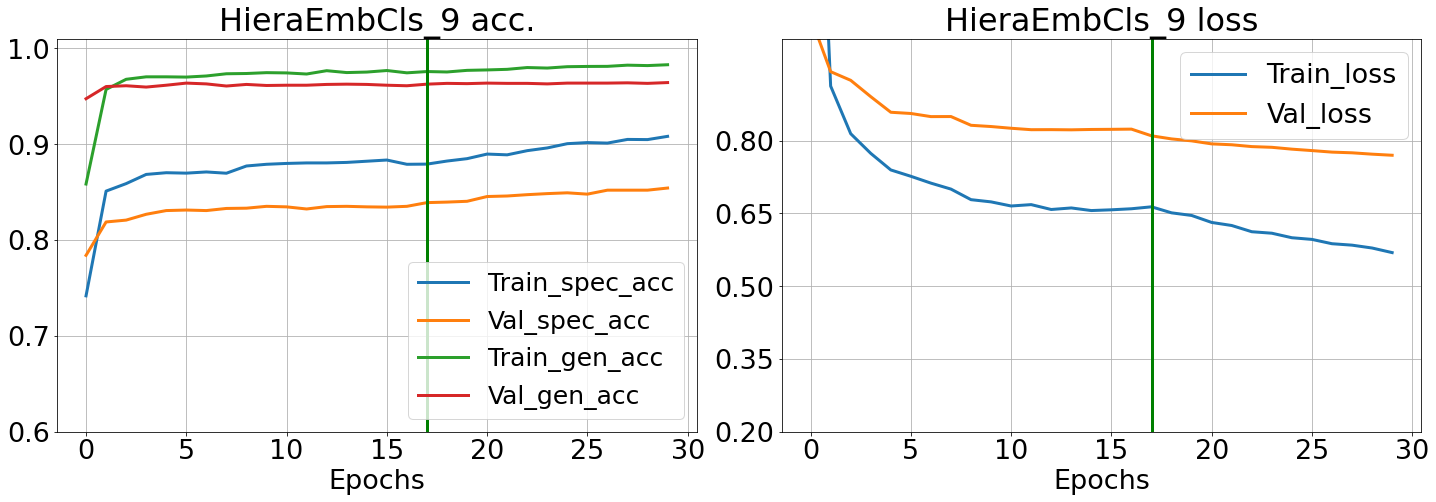

In [ ]:
# Combine histories from frozen and unfrozen models
history_acc    = [*history_frozen.history['species_accuracy'], *history_unfrozen.history['species_accuracy']]
history_valacc = [*history_frozen.history['val_species_accuracy'], *history_unfrozen.history['val_species_accuracy']]
history_gen_acc    = [*history_frozen.history['genus_accuracy'], *history_unfrozen.history['genus_accuracy']]
history_gen_valacc = [*history_frozen.history['val_genus_accuracy'], *history_unfrozen.history['val_genus_accuracy']]

history_los    = [*history_frozen.history['loss'], *history_unfrozen.history['loss']]
history_valoss = [*history_frozen.history['val_loss'], *history_unfrozen.history['val_loss']]

fig = plt.figure(figsize = (20, 7))
plt.subplot(1, 2, 1)
plt.plot(history_acc, linewidth = 3)
plt.plot(history_valacc, linewidth = 3)
plt.plot(history_gen_acc, linewidth = 3)
plt.plot(history_gen_valacc, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.6, 1.01)
plt.xticks(np.linspace(0, epochs, 7), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.6, 1.0, 5), fontsize = ticks_size)
plt.title(model_name + '_9 acc.', fontsize = title_size)
plt.legend(['Train_spec_acc', 'Val_spec_acc', 'Train_gen_acc', 'Val_gen_acc'], fontsize = label_size-2)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_los, linewidth = 3)
plt.plot(history_valoss, linewidth = 3)
plt.axvline(stop_ep, color='green', linewidth = 3)
plt.ylim(0.2, 1.01)
plt.xticks(np.linspace(0, epochs, 7), fontsize = ticks_size)
plt.xlabel('Epochs', fontsize = label_size)
plt.yticks(np.linspace(0.2, 0.8, 5), fontsize = ticks_size)
plt.title(model_name + '_9 loss', fontsize = title_size)
plt.legend(['Train_loss', 'Val_loss'], fontsize = label_size)
plt.grid()
plt.tight_layout(pad=0.8)
fig.savefig(model_name + '_' + inp_form + '_9_acc.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# Predict genus and species
pred_gens, pred_specs = predict_gen_spec(model, cv_set, model_name, genus_mapping, emb_matrix)

y_cv = np.asarray(y_cv)
correct_gens  = sum(pred_gens  == y_cv[:, 0])
correct_specs = sum(pred_specs == y_cv[:, 1])

print('Genus   acc: ' + str(np.round( correct_gens  / len(pred_gens),  4 )))
print('Species acc: ' + str(np.round( correct_specs / len(pred_specs), 4 )))

Genus   acc: 0.9643
Species acc: 0.8543


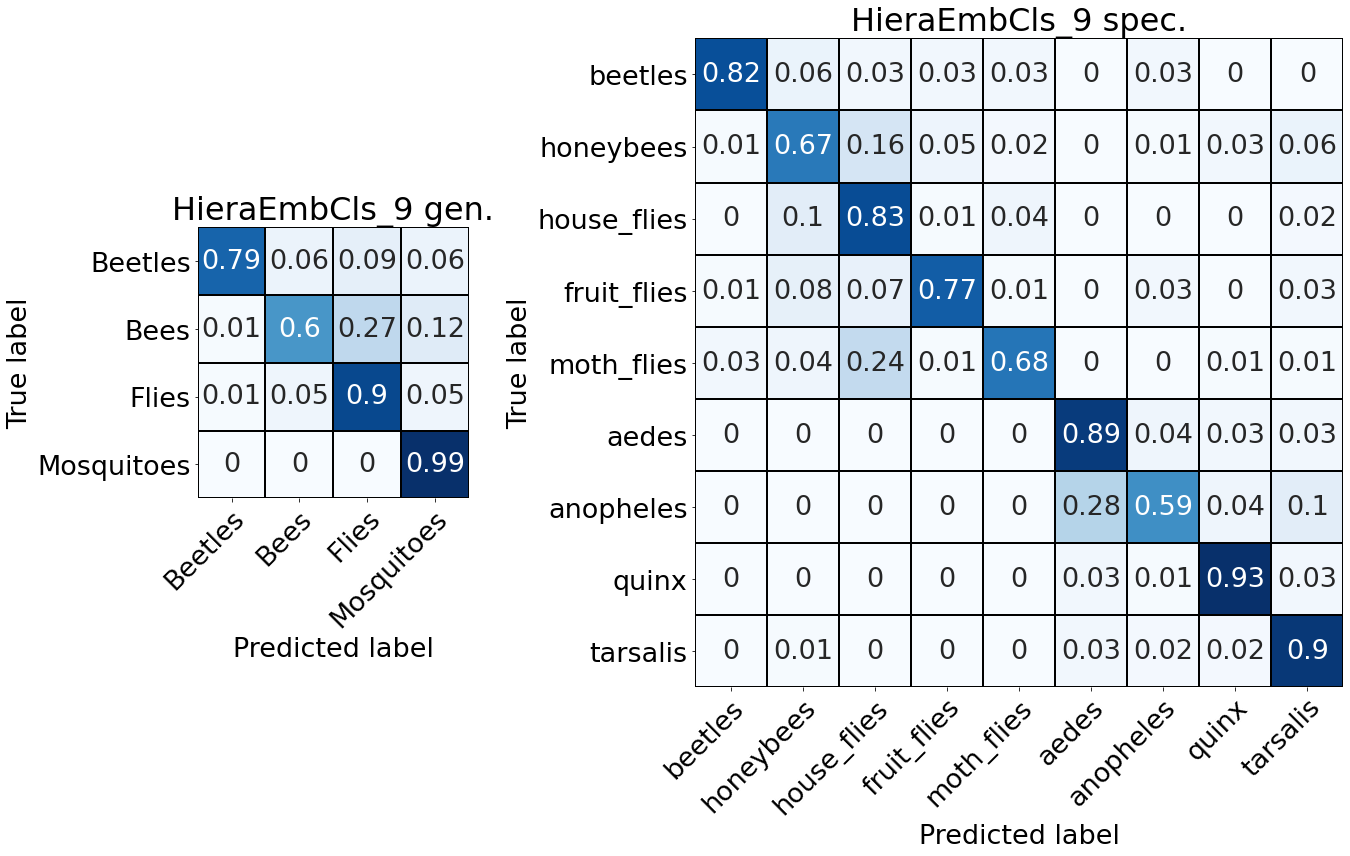

In [ ]:
# Build confusion matrices
gen_conf  = np.round( confusion_matrix(y_cv[:, 0], pred_gens,  normalize = 'true'), 2 )
spec_conf = np.round( confusion_matrix(y_cv[:, 1], pred_specs, normalize = 'true'), 2 )

fig = plt.figure(figsize = (20, 12))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
plt.subplot(gs[0])
plot_heatmap(gen_conf, xticklab = genus, yticklab = genus, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_9 gen.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)

plt.subplot(gs[1])
plot_heatmap(spec_conf, xticklab = species, yticklab = species, 
             xlab = 'Predicted label', ylab = 'True label', title = model_name + '_9 spec.',
             title_size = title_size, ticks_size = ticks_size, 
             label_size = label_size, item_size = ticks_size)
plt.tight_layout()
fig.savefig(model_name + '_' + inp_form + '_9_conf.eps', bbox_inches = 'tight')